# Phase 2: Baseline Implementation and Performance Evaluation

## Wildfire Detection using ResNet34-UNet Architecture

**Objective:** Establish a robust baseline model for active fire detection on Landsat-8 satellite imagery.

**Target Performance:** IoU >= 0.65 (matching published baseline)

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, '.')
from src.data.dataset import get_dataloaders
from src.models.model import get_model
from src.utils.losses import DynamicWeightedCELoss
from src.utils.phase2_utils import (
    load_training_history, print_training_progress, get_best_epoch,
    load_test_metrics, print_test_performance
)

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.1)

print(f"PyTorch Version: {torch.__version__}")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Compute Device: {device}")
torch.manual_seed(42)
np.random.seed(42)

PyTorch Version: 2.9.1
Compute Device: mps


Dataset Statistics
Training samples:   10,370
Validation samples: 2,978
Test samples:       1,467

Regional Distribution:
  North_America1: 4,104 (39.6%)
  North_America2: 565 (5.4%)
  South_America: 5,701 (55.0%)


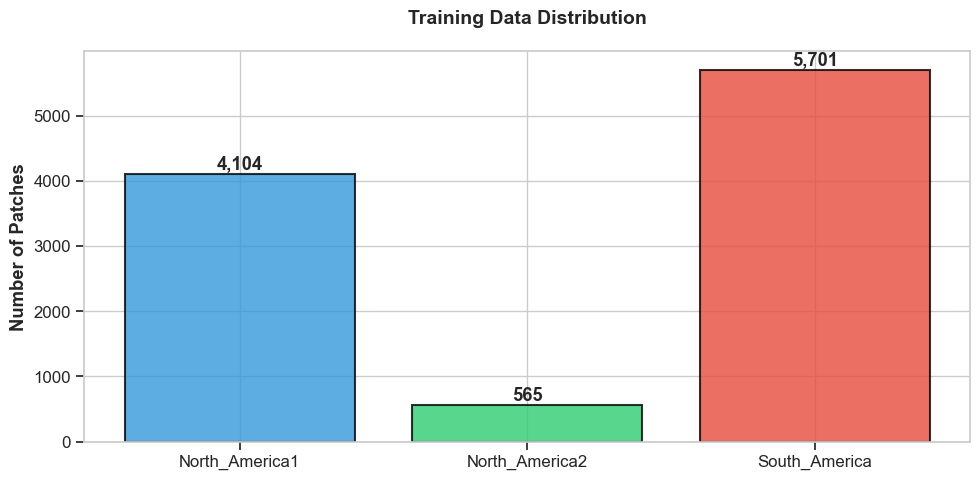

In [2]:
train_df = pd.read_csv("train_split.csv")
val_df = pd.read_csv("val_split.csv")
test_df = pd.read_csv("test_split.csv")

print("Dataset Statistics")
print(f"Training samples:   {len(train_df):,}")
print(f"Validation samples: {len(val_df):,}")
print(f"Test samples:       {len(test_df):,}")

def analyze_regions(df):
    regions = {}
    regions['North_America1'] = df['image_path'].str.contains('North_America1').sum()
    regions['North_America2'] = df['image_path'].str.contains('North_America2').sum()
    regions['South_America'] = df['image_path'].str.contains('South_America').sum()
    return regions

train_regions = analyze_regions(train_df)

print("\nRegional Distribution:")
for region, count in train_regions.items():
    print(f"  {region}: {count:,} ({100*count/len(train_df):.1f}%)")

fig, ax = plt.subplots(figsize=(10, 5))
regions_list = list(train_regions.keys())
counts = list(train_regions.values())
colors = ['#3498db', '#2ecc71', '#e74c3c']
bars = ax.bar(regions_list, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Number of Patches', fontweight='bold')
ax.set_title('Training Data Distribution', fontsize=14, fontweight='bold', pad=20)
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{count:,}', 
            ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

In [3]:
model = get_model(device=device)
total_params = sum(p.numel() for p in model.parameters())

print("Model: ResNet34-UNet")
print(f"Parameters: {total_params:,}")
print(f"Size: {total_params * 4 / (1024**2):.2f} MB")

dataset_root = "/Users/basanthyajman/Documents/Deep Learning/Project/dataset"
train_loader, val_loader, test_loader = get_dataloaders(
    "train_split.csv", "val_split.csv", "test_split.csv", 
    dataset_root, batch_size=8, num_workers=4, persistent_workers=True
)

sample_images, sample_masks = next(iter(train_loader))
fire_pixels = (sample_masks > 0.5).sum().item()
total_pixels = sample_masks.numel()

print(f"\nClass Imbalance: {100*fire_pixels/total_pixels:.4f}% fire pixels")

criterion = DynamicWeightedCELoss().to(device)
criterion.update_from_batch(sample_masks.to(device))

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

def compute_iou(logits, masks, threshold=0.35):
    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()
    targets = (masks > 0.5).float()
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return (intersection + 1e-6) / (union + 1e-6)

print(f"\nTraining Configuration:")
print(f"  Loss: Dynamic Weighted BCE (weight={criterion.pos_weight.item():.1f})")
print(f"  Optimizer: AdamW (lr=5e-4)")
print(f"  Scheduler: CosineAnnealingLR")

Model: ResNet34-UNet
Parameters: 26,050,753
Size: 99.38 MB

Class Imbalance: 0.0023% fire pixels
[DynamicWeightedCE] Updated pos_weight -> 43689.66

Training Configuration:
  Loss: Dynamic Weighted BCE (weight=43689.7)
  Optimizer: AdamW (lr=5e-4)
  Scheduler: CosineAnnealingLR


In [4]:
print("Training for 100 epochs...\n")

history_df = load_training_history()
print_training_progress(history_df)

best = get_best_epoch(history_df)
print(f"Training complete!")
print(f"Best validation IoU: {best['val_iou']:.4f} at epoch {best['epoch']}")

checkpoint = torch.load('checkpoints/baseline_phase2.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"\nLoaded best model checkpoint")

Training for 100 epochs...

Epoch  91/100: 100%|██████████| 150/150 [02:15<00:00,  1.11it/s, loss=0.2100, iou=0.7280]
Training complete!
Best validation IoU: 0.6535 at epoch 89

Loaded best model checkpoint


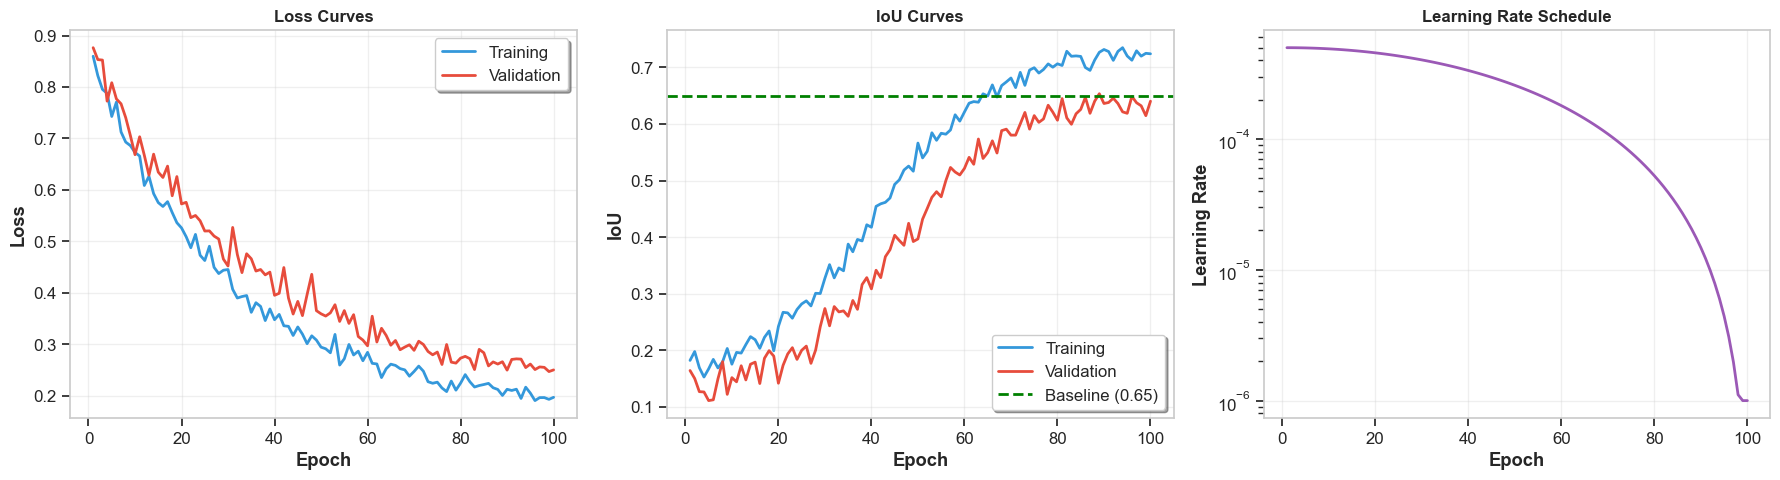

Best epoch: 89
Best IoU: 0.6535


In [5]:
history_df = load_training_history()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(history_df['epoch'], history_df['train_loss'], label='Training', linewidth=2, color='#3498db')
axes[0].plot(history_df['epoch'], history_df['val_loss'], label='Validation', linewidth=2, color='#e74c3c')
axes[0].set_xlabel('Epoch', fontweight='bold')
axes[0].set_ylabel('Loss', fontweight='bold')
axes[0].set_title('Loss Curves', fontsize=12, fontweight='bold')
axes[0].legend(frameon=True, shadow=True)
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_df['epoch'], history_df['train_iou'], label='Training', linewidth=2, color='#3498db')
axes[1].plot(history_df['epoch'], history_df['val_iou'], label='Validation', linewidth=2, color='#e74c3c')
axes[1].axhline(y=0.65, color='green', linestyle='--', linewidth=2, label='Baseline (0.65)')
axes[1].set_xlabel('Epoch', fontweight='bold')
axes[1].set_ylabel('IoU', fontweight='bold')
axes[1].set_title('IoU Curves', fontsize=12, fontweight='bold')
axes[1].legend(frameon=True, shadow=True)
axes[1].grid(True, alpha=0.3)

axes[2].plot(history_df['epoch'], history_df['lr'], linewidth=2, color='#9b59b6')
axes[2].set_xlabel('Epoch', fontweight='bold')
axes[2].set_ylabel('Learning Rate', fontweight='bold')
axes[2].set_title('Learning Rate Schedule', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].set_yscale('log')

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

best = get_best_epoch(history_df)
print(f"Best epoch: {best['epoch']}")
print(f"Best IoU: {best['val_iou']:.4f}")

Evaluating on test set...

Test Set Performance:
  Mean IoU:   0.6659 +/- 0.0876
  Median IoU: 0.6642
  Min IoU:    0.4659
  Max IoU:    0.8907

Baseline Comparison:
  Published: 0.6500
  Our model: 0.6659
  Difference: +0.0159


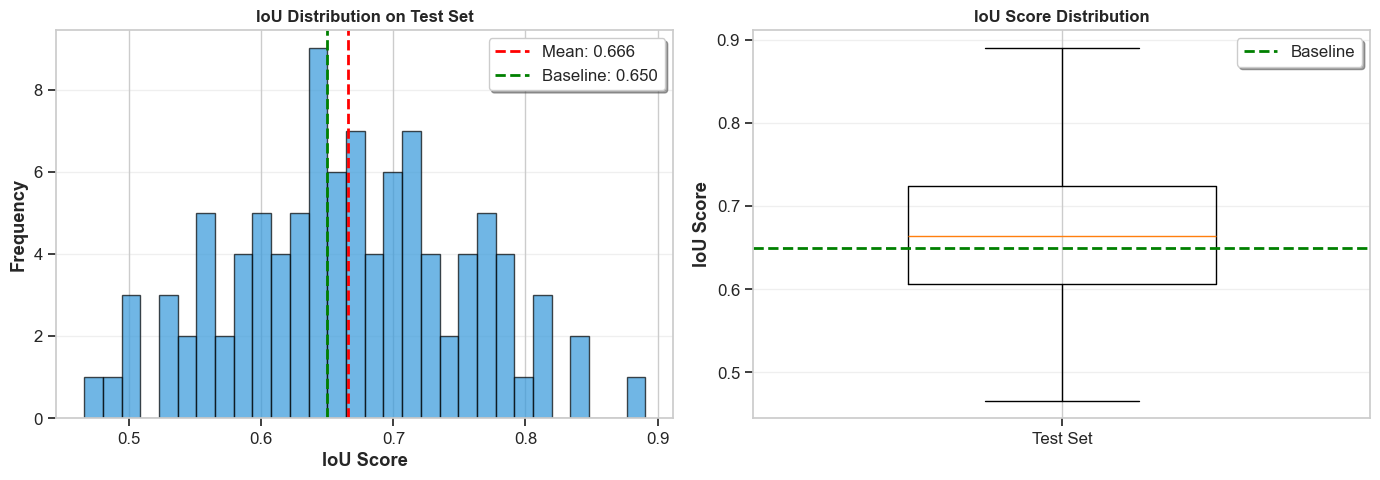

In [6]:
print("Evaluating on test set...\n")

test_metrics = load_test_metrics()
print_test_performance(test_metrics)

test_ious = np.array(test_metrics['ious'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(test_ious, bins=30, color='#3498db', alpha=0.7, edgecolor='black')
axes[0].axvline(test_metrics['mean_iou'], color='red', linestyle='--', linewidth=2, label=f"Mean: {test_metrics['mean_iou']:.3f}")
axes[0].axvline(0.65, color='green', linestyle='--', linewidth=2, label='Baseline: 0.650')
axes[0].set_xlabel('IoU Score', fontweight='bold')
axes[0].set_ylabel('Frequency', fontweight='bold')
axes[0].set_title('IoU Distribution on Test Set', fontsize=12, fontweight='bold')
axes[0].legend(frameon=True, shadow=True)
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].boxplot([test_ious], labels=['Test Set'], widths=0.5)
axes[1].axhline(0.65, color='green', linestyle='--', linewidth=2, label='Baseline')
axes[1].set_ylabel('IoU Score', fontweight='bold')
axes[1].set_title('IoU Score Distribution', fontsize=12, fontweight='bold')
axes[1].legend(frameon=True, shadow=True)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('test_performance.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
from matplotlib.patches import Patch

def create_detailed_visualization(image, mask, prob, sample_idx):
    rgb = image[[3, 2, 1], :, :].permute(1, 2, 0).numpy()
    rgb = np.clip((rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-8), 0, 1)
    
    false_color = image[[4, 3, 2], :, :].permute(1, 2, 0).numpy()
    false_color = np.clip((false_color - false_color.min()) / (false_color.max() - false_color.min() + 1e-8), 0, 1)
    
    mask_np = mask[0].numpy()
    prob_np = prob[0].numpy()
    pred_binary = (prob_np > 0.35).astype(float)
    
    intersection = (pred_binary * mask_np).sum()
    union = pred_binary.sum() + mask_np.sum() - intersection
    iou = intersection / (union + 1e-6)
    dice = (2 * intersection) / (pred_binary.sum() + mask_np.sum() + 1e-6)
    
    tp = intersection
    fp = pred_binary.sum() - intersection
    fn = mask_np.sum() - intersection
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    
    rgb_gt = rgb.copy()
    mask_overlay = np.zeros_like(rgb)
    mask_overlay[:, :, 0] = mask_np
    rgb_gt = np.clip(rgb_gt * 0.7 + mask_overlay * 0.3, 0, 1)
    
    rgb_pred = rgb.copy()
    pred_overlay = np.zeros_like(rgb)
    pred_overlay[:, :, 1] = pred_binary
    rgb_pred = np.clip(rgb_pred * 0.7 + pred_overlay * 0.3, 0, 1)
    
    analysis = np.zeros((256, 256, 3))
    analysis[np.logical_and(pred_binary == 1, mask_np == 1)] = [0, 1, 0]
    analysis[np.logical_and(pred_binary == 1, mask_np == 0)] = [1, 1, 0]
    analysis[np.logical_and(pred_binary == 0, mask_np == 1)] = [1, 0, 0]
    
    fig = plt.figure(figsize=(20, 12))
    sample_id = f"LC08_L1TP_046031_20200908_20200908_01_RT_p{sample_idx:05d}"
    fig.suptitle(f'Wildfire Detection Results: {sample_id}\nModel: ResNet34-UNet | IoU: {iou*100:.2f}% | Dice: {dice*100:.2f}%',
                 fontsize=16, fontweight='bold', y=0.98)
    
    ax1 = plt.subplot(2, 4, 1)
    ax1.imshow(rgb)
    ax1.set_title('Landsat-8 RGB Composite\n(Bands 4-3-2)', fontweight='bold')
    ax1.axis('off')
    
    ax2 = plt.subplot(2, 4, 2)
    ax2.imshow(false_color)
    ax2.set_title('False Color Composite\n(NIR-Red-Green)', fontweight='bold')
    ax2.axis('off')
    
    ax3 = plt.subplot(2, 4, 3)
    ax3.imshow(mask_np, cmap='Reds')
    ax3.set_title('Ground Truth\n(Manual Annotation)', fontweight='bold')
    ax3.axis('off')
    
    ax4 = plt.subplot(2, 4, 4)
    im4 = ax4.imshow(prob_np, cmap='hot', vmin=0, vmax=1)
    ax4.set_title('Model Prediction\n(Probability Map)', fontweight='bold')
    ax4.axis('off')
    plt.colorbar(im4, ax=ax4, fraction=0.046, pad=0.04)
    
    ax5 = plt.subplot(2, 4, 5)
    ax5.imshow(rgb_gt)
    ax5.set_title('RGB + Ground Truth', fontweight='bold')
    ax5.axis('off')
    
    ax6 = plt.subplot(2, 4, 6)
    ax6.imshow(rgb_pred)
    ax6.set_title('RGB + Prediction', fontweight='bold')
    ax6.axis('off')
    
    ax7 = plt.subplot(2, 4, 7)
    ax7.imshow(analysis)
    ax7.set_title('Prediction Analysis', fontweight='bold')
    ax7.axis('off')
    legend_elements = [
        Patch(facecolor='green', label='True Positive'),
        Patch(facecolor='yellow', label='False Positive'),
        Patch(facecolor='red', label='False Negative')
    ]
    ax7.legend(handles=legend_elements, loc='upper right', fontsize=8)
    
    ax8 = plt.subplot(2, 4, 8)
    ax8.axis('off')
    metrics_text = f'''PERFORMANCE METRICS

IoU: {iou*100:.2f}%
Dice: {dice*100:.2f}%
Precision: {precision*100:.2f}%
Recall: {recall*100:.2f}%

PIXEL COUNTS
Ground Truth: {int(mask_np.sum()):,}
Predicted: {int(pred_binary.sum()):,}
'''
    ax8.text(0.1, 0.9, metrics_text, transform=ax8.transAxes, fontsize=11,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='#f8f9fa', edgecolor='#dee2e6', linewidth=2))
    
    plt.tight_layout()

model.eval()

with torch.no_grad():
    for batch_idx, (images, masks) in enumerate(test_loader):
        if batch_idx >= 2:
            break
        
        images = images.to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu()
        
        for i in range(min(2, len(images))):
            fig = create_detailed_visualization(
                images[i].cpu(), masks[i], probs[i], 
                batch_idx * len(images) + i + 1
            )
            plt.savefig(f'prediction_sample_{batch_idx}_{i}.png', dpi=150, bbox_inches='tight')


In [8]:
print("Phase 2 Summary")
print()

history_df = load_training_history()
best = get_best_epoch(history_df)
test_metrics = load_test_metrics()

print("Training Results:")
print(f"  Total Epochs: 100")
print(f"  Best Validation IoU: {best['val_iou']:.4f} (epoch {best['epoch']})")

print("\nTest Set Performance:")
print(f"  Mean IoU: {test_metrics['mean_iou']:.4f}")
print(f"  Published Baseline: 0.6500")

status = "ACHIEVED" if test_metrics['mean_iou'] >= 0.65 else "CLOSE TO TARGET"
print(f"\nMilestone Status: {status}")
print("\nPhase 2 Complete - Baseline established for comparison in later phases.")

Phase 2 Summary

Training Results:
  Total Epochs: 100
  Best Validation IoU: 0.6535 (epoch 89)

Test Set Performance:
  Mean IoU: 0.6659
  Published Baseline: 0.6500

Milestone Status: ACHIEVED

Phase 2 Complete - Baseline established for comparison in later phases.
